In [32]:
on_aws_instance = False

# Adjustable parameters:

nb_epoch = 5 

steering_correction = 0.4

img_size = (160,320,3)
img_cropping = ((70,25), (0,0))

data_base_path = '../Driving_Data/'
#data_folder_names = ['Track_1_Center/']
#data_folder_names = ['Track_1_Recover/']
data_folder_names = ['Track_1_Center/','Track_1_Recover/']
log_file_name = 'driving_log.csv'

# Set max_num_samples = -1 to do all samples
# Set to a small value for quick testing on slow processor
max_num_samples = 100


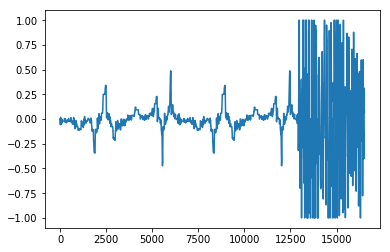

In [33]:
import csv
import cv2
import numpy as np
import sklearn

driving_log_lines = []
image_paths = []
steering_angles = []
testing_angles = []

for data_folder_name in data_folder_names:    
    
    with open(data_base_path+data_folder_name+log_file_name) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:            
            driving_log_lines.append(line)
    
            
    for line in driving_log_lines:
        
        # create adjusted steering steering_angles for the side camera images
        # In steering_adjustment, the key is in {0,1,2}
        # 0 is for center image, 1 is for left image, 2 is for right image
        steering_adjustment = {0:0, 1: steering_correction, 2: -steering_correction}
        
        testing_angles.append(float(line[3]))

        # read in images from center, left and right cameras
        for line_idx in range(3):
            
            img_path = line[line_idx]
            img_file_name = img_path.split('/')[-1]
            image_path = data_base_path+data_folder_name+'IMG/'+img_file_name
            image_paths.append(image_path)
            
            steering_angle = float(line[3]) + steering_adjustment[line_idx]            
            steering_angles.append(float(steering_angle))            

samples = list(zip(image_paths,steering_angles))

samples = samples[0:max_num_samples]

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)


    
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                image_path, angle = batch_sample
                image = cv2.imread(image_path)
                images.append(image)
                angles.append(angle)

            augmented_images = []
            augmented_angles = []
            for image,angle in zip(images,angles):
                augmented_images.append(image)
                augmented_angles.append(angle)
                augmented_images.append(cv2.flip(image,1))
                augmented_angles.append(angle*-1.0)    

            # trim image to only see section with road
            # TODO! Trim!
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_angles)
            yield sklearn.utils.shuffle(X_train, y_train)
            

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(testing_angles)
plt.show()

In [27]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Convolution2D, Cropping2D

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse',optimizer='adam')
#model.fit(X_train,y_train,validation_split=0.2,shuffle=True,nb_epoch=nb_epoch)
history_object = model.fit_generator(train_generator, samples_per_epoch= 
            2*len(train_samples), validation_data=validation_generator, 
            nb_val_samples=2*len(validation_samples), nb_epoch=nb_epoch, 
            verbose=1)            

model.save('model_testing.h5')

Epoch 1/5
1600/1600 [==============================] - 27s - loss: 0.0209 - val_loss: 0.0042
Epoch 2/5
1600/1600 [==============================] - 25s - loss: 0.0027 - val_loss: 0.0016
Epoch 3/5
1600/1600 [==============================] - 25s - loss: 7.8400e-04 - val_loss: 5.1330e-04
Epoch 4/5
1600/1600 [==============================] - 26s - loss: 4.8299e-04 - val_loss: 5.6484e-04
Epoch 5/5
1600/1600 [==============================] - 25s - loss: 4.5677e-04 - val_loss: 4.8386e-04


dict_keys(['loss', 'val_loss'])


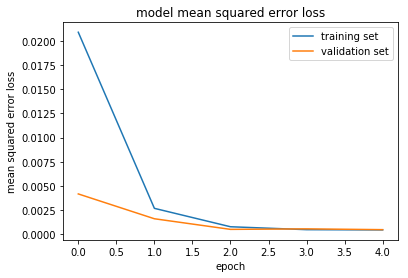

In [29]:
import matplotlib.pyplot as plt

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()